# <div style="text-align: right"> Chapter __20__</div>

# __Many models with purrr and broom__

In [1]:
# config
repr_html.tbl_df <- function(obj, ..., rows = 6) repr:::repr_html.data.frame(obj, ..., rows = rows)
options(dplyr.summarise.inform = FALSE)

## __Introduction__

In this chapter you’re going to learn three powerful ideas that help
you to work with large numbers of models with ease:
* Using many simple models to better understand complex
datasets.
* Using list-columns to store arbitrary data structures in a data
frame. For example, this will allow you to have a column that
contains linear models.
* Using the broom package, by David Robinson, to turn models
into tidy data. This is a powerful technique for working with
large numbers of models because once you have tidy data, you
can apply all of the techniques that you’ve learned about earlier
in the book.

We’ll start by diving into a motivating example using data about life
expectancy around the world. It’s a small dataset but it illustrates
how important modeling can be for improving your visualizations.
We’ll use a large number of simple models to partition out some of
the strongest signals so we can see the subtler signals that remain.
We’ll also see how model summaries can help us pick out outliers
and unusual trends.

In [2]:
library(modelr)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [5]:
library(gapminder)

In [6]:
gapminder

country,continent,year,lifeExp,pop,gdpPercap
<fct>,<fct>,<int>,<dbl>,<int>,<dbl>
Afghanistan,Asia,1952,28.801,8425333,779.4453
Afghanistan,Asia,1957,30.332,9240934,820.8530
Afghanistan,Asia,1962,31.997,10267083,853.1007
⋮,⋮,⋮,⋮,⋮,⋮
Zimbabwe,Africa,1997,46.809,11404948,792.4500
Zimbabwe,Africa,2002,39.989,11926563,672.0386
Zimbabwe,Africa,2007,43.487,12311143,469.7093


In this case study, we’re going to focus on just three variables to
answer the question “How does life expectancy ( lifeExp ) change
over time ( year ) for each country ( country )?” A good place to start
is with a plot:

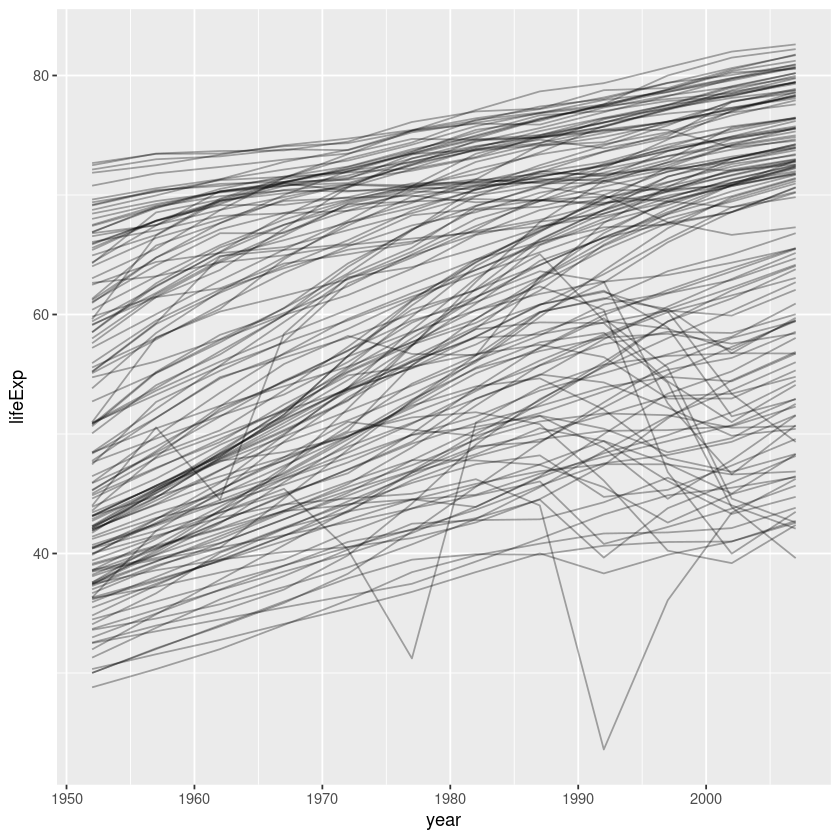

In [7]:
gapminder %>%
    ggplot(aes(year, lifeExp, group = country)) +
        geom_line(alpha = 1/3)

This is a small dataset: it only has ~1,700 observations and 3 variables. But it’s still hard to see what’s going on! Overall, it looks like life expectancy has been steadily improving. However, if you look
closely, you might notice some countries that don’t follow this pat‐
tern. How can we make those countries easier to see?

One way is to use the same approach as in the last chapter: there’s a
strong signal (overall linear growth) that makes it hard to see subtler
trends. We’ll tease these factors apart by fitting a model with a linear
trend. The model captures steady growth over time, and the residuals will show what’s left.
You already know how to do that if we had a single country:

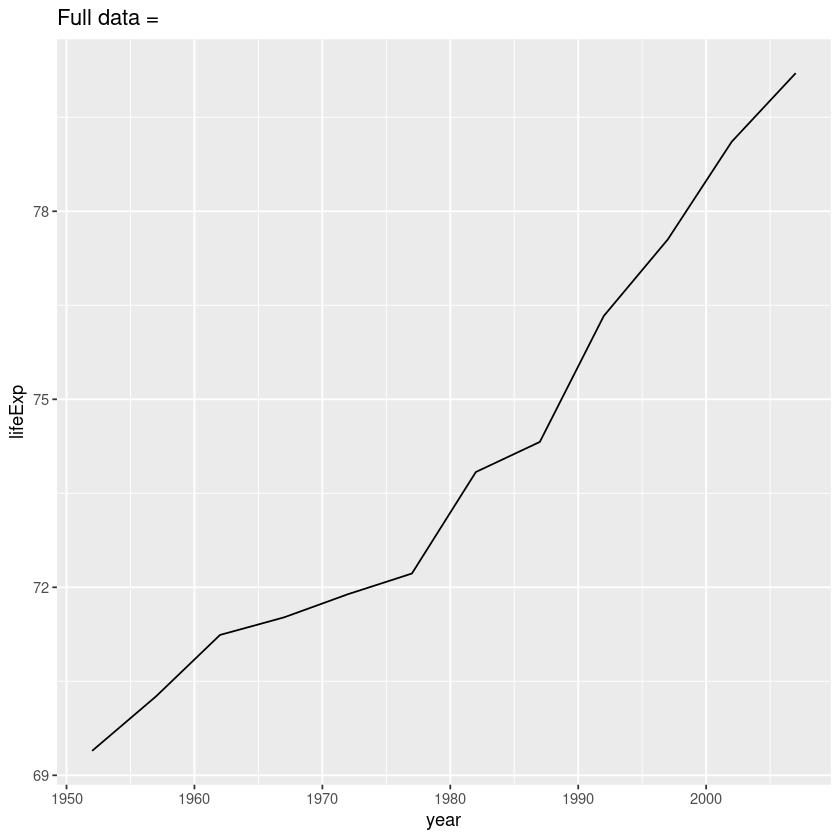

In [9]:
nz <- filter(gapminder, country == 'New Zealand')
nz %>%
    ggplot(aes(year, lifeExp)) +
        geom_line() +
        ggtitle('Full data = ')

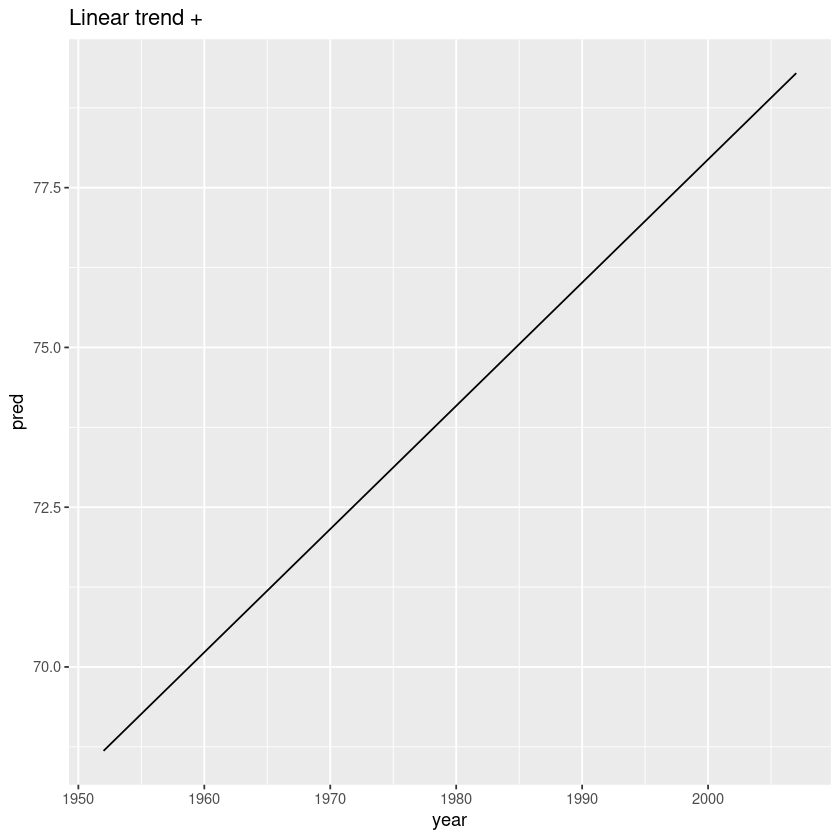

In [10]:
nz_mod <- lm(lifeExp ~ year, data = nz)
nz %>%
    add_predictions(nz_mod) %>%
    ggplot(aes(year, pred)) +
        geom_line() +
        ggtitle('Linear trend +')

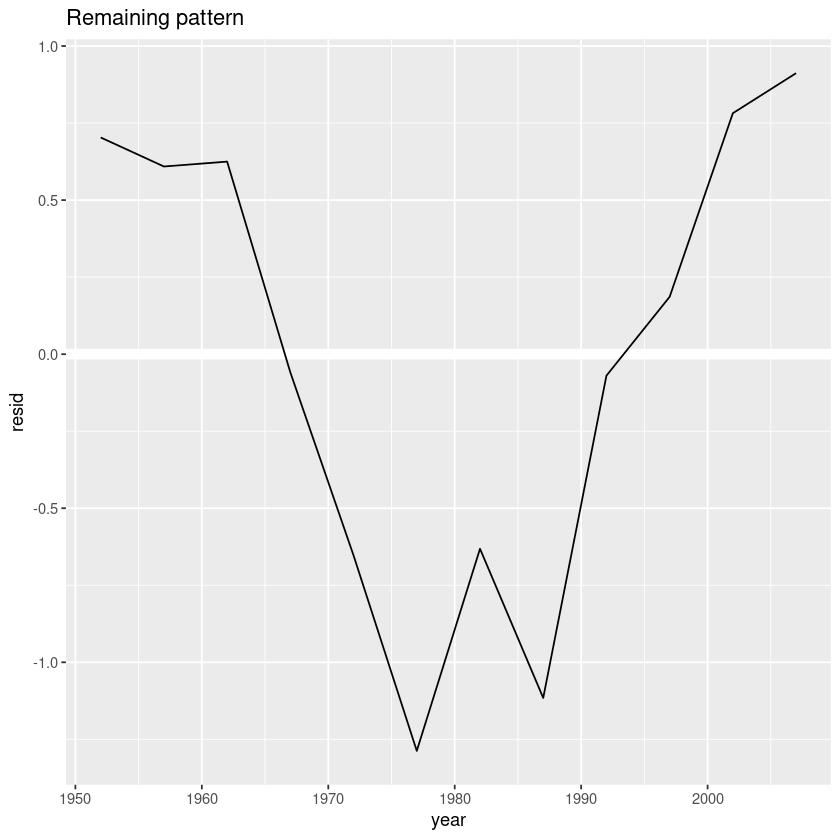

In [11]:
nz %>%
    add_residuals(nz_mod) %>%
    ggplot(aes(year, resid)) +
        geom_hline(yintercept = 0,
                   color = 'white',
                   size = 3) +
        geom_line() +
        ggtitle('Remaining pattern')

### Nested Data
You could imagine copying and pasting that code multiple times;
but you’ve already learned a better way! Extract out the common
code with a function and repeat using a map function from purrr.
This problem is structured a little differently to what you’ve seen
before. Instead of repeating an action for each variable, we want to
repeat an action for each country, a subset of rows. To do that, we
need a new data structure: the nested data frame. To create a nested
data frame we start with a grouped data frame, and “nest” it:

In [12]:
by_country <- gapminder %>%
    group_by(country, continent) %>%
    nest()

In [13]:
by_country

country,continent,data
<fct>,<fct>,<list>
Afghanistan,Asia,"1.952000e+03, 1.957000e+03, 1.962000e+03, 1.967000e+03, 1.972000e+03, 1.977000e+03, 1.982000e+03, 1.987000e+03, 1.992000e+03, 1.997000e+03, 2.002000e+03, 2.007000e+03, 2.880100e+01, 3.033200e+01, 3.199700e+01, 3.402000e+01, 3.608800e+01, 3.843800e+01, 3.985400e+01, 4.082200e+01, 4.167400e+01, 4.176300e+01, 4.212900e+01, 4.382800e+01, 8.425333e+06, 9.240934e+06, 1.026708e+07, 1.153797e+07, 1.307946e+07, 1.488037e+07, 1.288182e+07, 1.386796e+07, 1.631792e+07, 2.222742e+07, 2.526840e+07, 3.188992e+07, 7.794453e+02, 8.208530e+02, 8.531007e+02, 8.361971e+02, 7.399811e+02, 7.861134e+02, 9.780114e+02, 8.523959e+02, 6.493414e+02, 6.353414e+02, 7.267341e+02, 9.745803e+02"
Albania,Europe,"1952.000, 1957.000, 1962.000, 1967.000, 1972.000, 1977.000, 1982.000, 1987.000, 1992.000, 1997.000, 2002.000, 2007.000, 55.230, 59.280, 64.820, 66.220, 67.690, 68.930, 70.420, 72.000, 71.581, 72.950, 75.651, 76.423, 1282697.000, 1476505.000, 1728137.000, 1984060.000, 2263554.000, 2509048.000, 2780097.000, 3075321.000, 3326498.000, 3428038.000, 3508512.000, 3600523.000, 1601.056, 1942.284, 2312.889, 2760.197, 3313.422, 3533.004, 3630.881, 3738.933, 2497.438, 3193.055, 4604.212, 5937.030"
Algeria,Africa,"1952.000, 1957.000, 1962.000, 1967.000, 1972.000, 1977.000, 1982.000, 1987.000, 1992.000, 1997.000, 2002.000, 2007.000, 43.077, 45.685, 48.303, 51.407, 54.518, 58.014, 61.368, 65.799, 67.744, 69.152, 70.994, 72.301, 9279525.000, 10270856.000, 11000948.000, 12760499.000, 14760787.000, 17152804.000, 20033753.000, 23254956.000, 26298373.000, 29072015.000, 31287142.000, 33333216.000, 2449.008, 3013.976, 2550.817, 3246.992, 4182.664, 4910.417, 5745.160, 5681.359, 5023.217, 4797.295, 5288.040, 6223.367"
⋮,⋮,⋮
"Yemen, Rep.",Asia,"1.952000e+03, 1.957000e+03, 1.962000e+03, 1.967000e+03, 1.972000e+03, 1.977000e+03, 1.982000e+03, 1.987000e+03, 1.992000e+03, 1.997000e+03, 2.002000e+03, 2.007000e+03, 3.254800e+01, 3.397000e+01, 3.518000e+01, 3.698400e+01, 3.984800e+01, 4.417500e+01, 4.911300e+01, 5.292200e+01, 5.559900e+01, 5.802000e+01, 6.030800e+01, 6.269800e+01, 4.963829e+06, 5.498090e+06, 6.120081e+06, 6.740785e+06, 7.407075e+06, 8.403990e+06, 9.657618e+06, 1.121934e+07, 1.336800e+07, 1.582650e+07, 1.870126e+07, 2.221174e+07, 7.817176e+02, 8.048305e+02, 8.256232e+02, 8.624421e+02, 1.265047e+03, 1.829765e+03, 1.977557e+03, 1.971742e+03, 1.879497e+03, 2.117485e+03, 2.234821e+03, 2.280770e+03"
Zambia,Africa,"1952.000, 1957.000, 1962.000, 1967.000, 1972.000, 1977.000, 1982.000, 1987.000, 1992.000, 1997.000, 2002.000, 2007.000, 42.038, 44.077, 46.023, 47.768, 50.107, 51.386, 51.821, 50.821, 46.100, 40.238, 39.193, 42.384, 2672000.000, 3016000.000, 3421000.000, 3900000.000, 4506497.000, 5216550.000, 6100407.000, 7272406.000, 8381163.000, 9417789.000, 10595811.000, 11746035.000, 1147.389, 1311.957, 1452.726, 1777.077, 1773.498, 1588.688, 1408.679, 1213.315, 1210.885, 1071.354, 1071.614, 1271.212"
Zimbabwe,Africa,"1.952000e+03, 1.957000e+03, 1.962000e+03, 1.967000e+03, 1.972000e+03, 1.977000e+03, 1.982000e+03, 1.987000e+03, 1.992000e+03, 1.997000e+03, 2.002000e+03, 2.007000e+03, 4.845100e+01, 5.046900e+01, 5.235800e+01, 5.399500e+01, 5.563500e+01, 5.767400e+01, 6.036300e+01, 6.235100e+01, 6.037700e+01, 4.680900e+01, 3.998900e+01, 4.348700e+01, 3.080907e+06, 3.646340e+06, 4.277736e+06, 4.995432e+06, 5.861135e+06, 6.642107e+06, 7.636524e+06, 9.216418e+06, 1.070434e+07, 1.140495e+07, 1.192656e+07, 1.231114e+07, 4.068841e+02, 5.187643e+02, 5.272722e+02, 5.697951e+02, 7.993622e+02, 6.855877e+02, 7.888550e+02, 7.061573e+02, 6.934208e+02, 7.924500e+02, 6.720386e+02, 4.697093e+02"


This creates a data frame that has one row per group (per country),
and a rather unusual column: data . data is a list of data frames (or
tibbles, to be precise). This seems like a crazy idea: we have a data
frame with a column that is a list of other data frames! I’ll explain
shortly why I think this is a good idea.

The data column is a little tricky to look at because it’s a moderately
complicated list, and we’re still working on good tools to explore
these objects. Unfortunately using str() is not recommended as it
will often produce very long output. But if you pluck out a single
element from the data column you’ll see that it contains all the data
for that country (in this case, Afghanistan):

In [14]:
by_country$data[[1]]

year,lifeExp,pop,gdpPercap
<int>,<dbl>,<int>,<dbl>
1952,28.801,8425333,779.4453
1957,30.332,9240934,820.8530
1962,31.997,10267083,853.1007
⋮,⋮,⋮,⋮
1997,41.763,22227415,635.3414
2002,42.129,25268405,726.7341
2007,43.828,31889923,974.5803


Note the difference between a standard grouped data frame and a
nested data frame: in a grouped data frame, each row is an observation; in a nested data frame, each row is a group. Another way to
think about a nested dataset is we now have a meta-observation: a
row that represents the complete time course for a country, rather
than a single point in time.

### __List-Columns__

Now that we have our nested data frame, we’re in a good position to
fit some models. We have a model-fitting function:

In [15]:
country_model <- function(df) {
    lm(lifeExp ~ year, data = df)
}

And we want to apply it to every data frame. The data frames are in
a list, so we can use `purrr::map()` to apply country_model to each
element:

In [16]:
models <- map(by_country$data, country_model)

However, rather than leaving the list of models as a free-floating
object, I think it’s better to store it as a column in the by_country
data frame. Storing related objects in columns is a key part of the
value of data frames, and why I think list-columns are such a good
idea. In the course of working with these countries, we are going to
have lots of lists where we have one element per country. So why not
store them all together in one data frame?

In other words, instead of creating a new object in the global envi‐
ronment, we’re going to create a new variable in the by_country
data frame. That’s a job for `dplyr::mutate()` :

In [17]:
by_country <- by_country %>%
    mutate(model = map(data, country_model))

In [18]:
by_country

country,continent,data,model
<fct>,<fct>,<list>,<list>
Afghanistan,Asia,"1.952000e+03, 1.957000e+03, 1.962000e+03, 1.967000e+03, 1.972000e+03, 1.977000e+03, 1.982000e+03, 1.987000e+03, 1.992000e+03, 1.997000e+03, 2.002000e+03, 2.007000e+03, 2.880100e+01, 3.033200e+01, 3.199700e+01, 3.402000e+01, 3.608800e+01, 3.843800e+01, 3.985400e+01, 4.082200e+01, 4.167400e+01, 4.176300e+01, 4.212900e+01, 4.382800e+01, 8.425333e+06, 9.240934e+06, 1.026708e+07, 1.153797e+07, 1.307946e+07, 1.488037e+07, 1.288182e+07, 1.386796e+07, 1.631792e+07, 2.222742e+07, 2.526840e+07, 3.188992e+07, 7.794453e+02, 8.208530e+02, 8.531007e+02, 8.361971e+02, 7.399811e+02, 7.861134e+02, 9.780114e+02, 8.523959e+02, 6.493414e+02, 6.353414e+02, 7.267341e+02, 9.745803e+02","-507.5343, 0.2753287, -1.106295, -0.9519382, -0.6635816, -0.01722494, 0.6741317, 1.647488, 1.686845, 1.278202, 0.7535583, -0.5340851, -1.544728, -1.222372, -129.8305, 16.46226, -0.3108827, 0.2892301, 0.934343, 1.861456, 1.854569, 1.399681, 0.8287943, -0.5050929, -1.56198, -1.285867, 2, 29.90729, 31.28394, 32.66058, 34.03722, 35.41387, 36.79051, 38.16716, 39.5438, 40.92044, 42.29709, 43.67373, 45.05037, 0, 1, -3.464102, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, -6857.189, 59.7913, 0.1896554, 0.1060312, 0.02240704, -0.06121716, -0.1448414, -0.2284656, -0.3120898, -0.395714, -0.4793382, -0.5629624, 1.288675, 1.27328, 1, 2, 1e-07, 2, 10, lm(formula = lifeExp ~ year, data = df), lifeExp ~ year, 28.801, 30.332, 31.997, 34.02, 36.088, 38.438, 39.854, 40.822, 41.674, 41.763, 42.129, 43.828, 1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002, 2007"
Albania,Europe,"1952.000, 1957.000, 1962.000, 1967.000, 1972.000, 1977.000, 1982.000, 1987.000, 1992.000, 1997.000, 2002.000, 2007.000, 55.230, 59.280, 64.820, 66.220, 67.690, 68.930, 70.420, 72.000, 71.581, 72.950, 75.651, 76.423, 1282697.000, 1476505.000, 1728137.000, 1984060.000, 2263554.000, 2509048.000, 2780097.000, 3075321.000, 3326498.000, 3428038.000, 3508512.000, 3600523.000, 1601.056, 1942.284, 2312.889, 2760.197, 3313.422, 3533.004, 3630.881, 3738.933, 2497.438, 3193.055, 4604.212, 5937.030","-594.0725, 0.3346832, -3.999128, -1.622544, 2.24404, 1.970624, 1.767207, 1.333791, 1.150375, 1.056959, -1.035457, -1.339873, -0.312289, -1.213705, -237.0586, 20.01115, 3.248124, 2.926981, 2.675838, 2.194694, 1.963551, 1.822408, -0.3177351, -0.6698783, 0.3099785, -0.6391646, 2, 59.22913, 60.90254, 62.57596, 64.24938, 65.92279, 67.59621, 69.26962, 70.94304, 72.61646, 74.28987, 75.96329, 77.63671, 0, 1, -3.464102, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, -6857.189, 59.7913, 0.1896554, 0.1060312, 0.02240704, -0.06121716, -0.1448414, -0.2284656, -0.3120898, -0.395714, -0.4793382, -0.5629624, 1.288675, 1.27328, 1, 2, 1e-07, 2, 10, lm(formula = lifeExp ~ year, data = df), lifeExp ~ year, 55.23, 59.28, 64.82, 66.22, 67.69, 68.93, 70.42, 72, 71.581, 72.95, 75.651, 76.423, 1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002, 2007"
Algeria,Africa,"1952.000, 1957.000, 1962.000, 1967.000, 1972.000, 1977.000, 1982.000, 1987.000, 1992.000, 1997.000, 2002.000, 2007.000, 43.077, 45.685, 48.303, 51.407, 54.518, 58.014, 61.368, 65.799, 67.744, 69.152, 70.994, 72.301, 9279525.000, 10270856.000, 11000948.000, 12760499.000, 14760787.000, 17152804.000, 20033753.000, 23254956.000, 26298373.000, 29072015.000, 31287142.000, 33333216.000, 2449.008, 3013.976, 2550.817, 3246.992, 4182.664, 4910.417, 5745.160, 5681.359, 5023.217, 4797.295, 5288.040, 6223.367","-1067.859, 0.5692797, -0.2979744, -0.536373, -0.7647716, -0.5071702, -0.2425688, 0.4070326, 0.914634, 2.499235, 1.597837, 0.1594382, -0.8449604, -2.384359, -204.4865, 34.03798, -0.6280719, -0.4013136, -0.1675554, 0.4512029, 0.9279612, 2.481719, 1.549478, 0.08023599, -0.9550057, -2.525247, 2, 43.37497, 46.22137, 49.06777, 51.91417, 54.76057, 57.60697, 6

This has a big advantage: because all the related objects are stored
together, you don’t need to manually keep them in sync when you
filter or arrange. The semantics of the data frame takes care of that
for you:

In [20]:
by_country %>%
    filter(continent == 'Europe')

country,continent,data,model
<fct>,<fct>,<list>,<list>
Albania,Europe,"1952.000, 1957.000, 1962.000, 1967.000, 1972.000, 1977.000, 1982.000, 1987.000, 1992.000, 1997.000, 2002.000, 2007.000, 55.230, 59.280, 64.820, 66.220, 67.690, 68.930, 70.420, 72.000, 71.581, 72.950, 75.651, 76.423, 1282697.000, 1476505.000, 1728137.000, 1984060.000, 2263554.000, 2509048.000, 2780097.000, 3075321.000, 3326498.000, 3428038.000, 3508512.000, 3600523.000, 1601.056, 1942.284, 2312.889, 2760.197, 3313.422, 3533.004, 3630.881, 3738.933, 2497.438, 3193.055, 4604.212, 5937.030","-594.0725, 0.3346832, -3.999128, -1.622544, 2.24404, 1.970624, 1.767207, 1.333791, 1.150375, 1.056959, -1.035457, -1.339873, -0.312289, -1.213705, -237.0586, 20.01115, 3.248124, 2.926981, 2.675838, 2.194694, 1.963551, 1.822408, -0.3177351, -0.6698783, 0.3099785, -0.6391646, 2, 59.22913, 60.90254, 62.57596, 64.24938, 65.92279, 67.59621, 69.26962, 70.94304, 72.61646, 74.28987, 75.96329, 77.63671, 0, 1, -3.464102, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, -6857.189, 59.7913, 0.1896554, 0.1060312, 0.02240704, -0.06121716, -0.1448414, -0.2284656, -0.3120898, -0.395714, -0.4793382, -0.5629624, 1.288675, 1.27328, 1, 2, 1e-07, 2, 10, lm(formula = lifeExp ~ year, data = df), lifeExp ~ year, 55.23, 59.28, 64.82, 66.22, 67.69, 68.93, 70.42, 72, 71.581, 72.95, 75.651, 76.423, 1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002, 2007"
Austria,Europe,"1952.000, 1957.000, 1962.000, 1967.000, 1972.000, 1977.000, 1982.000, 1987.000, 1992.000, 1997.000, 2002.000, 2007.000, 66.800, 67.480, 69.540, 70.140, 70.630, 72.170, 73.180, 74.940, 76.040, 77.510, 78.980, 79.829, 6927772.000, 6965860.000, 7129864.000, 7376998.000, 7544201.000, 7568430.000, 7574613.000, 7578903.000, 7914969.000, 8069876.000, 8148312.000, 8199783.000, 6137.076, 8842.598, 10750.721, 12834.602, 16661.626, 19749.422, 21597.084, 23687.826, 27042.019, 29095.921, 32417.608, 36126.493","-405.9205, 0.2419923, 0.3515385, -0.1784231, 0.6716154, 0.06165385, -0.6583077, -0.3282692, -0.5282308, 0.02180769, -0.08815385, 0.1718846, 0.4319231, 0.07096154, -253.2371, 14.46904, 0.6311732, 0.004321666, -0.7325299, -0.4193814, -0.636233, -0.1030846, -0.2299361, 0.01321234, 0.2563608, -0.1214908, 2, 66.44846, 67.65842, 68.86838, 70.07835, 71.28831, 72.49827, 73.70823, 74.91819, 76.12815, 77.33812, 78.54808, 79.75804, 0, 1, -3.464102, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, -6857.189, 59.7913, 0.1896554, 0.1060312, 0.02240704, -0.06121716, -0.1448414, -0.2284656, -0.3120898, -0.395714, -0.4793382, -0.5629624, 1.288675, 1.27328, 1, 2, 1e-07, 2, 10, lm(formula = lifeExp ~ year, data = df), lifeExp ~ year, 66.8, 67.48, 69.54, 70.14, 70.63, 72.17, 73.18, 74.94, 76.04, 77.51, 78.98, 79.829, 1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002, 2007"
Belgium,Europe,"1952.000, 1957.000, 1962.000, 1967.000, 1972.000, 1977.000, 1982.000, 1987.000, 1992.000, 1997.000, 2002.000, 2007.000, 68.000, 69.240, 70.250, 70.940, 71.440, 72.800, 73.930, 75.350, 76.460, 77.530, 78.320, 79.441, 8730405.000, 8989111.000, 9218400.000, 9556500.000, 9709100.000, 9821800.000, 9856303.000, 9870200.000, 10045622.000, 10199787.000, 10311970.000, 10392226.000, 8343.105, 9714.961, 10991.207, 13149.041, 16672.144, 19117.974, 20979.846, 22525.563, 25575.571, 27561.197, 30485.884, 33692.605","-340.2412, 0.2090846, 0.1080769, 0.3026538, 0.2672308, -0.08819231, -0.6336154, -0.3190385, -0.2344615, 0.1401154, 0.2046923, 0.2292692, -0.02615385, 0.04942308, -255.1025, 12.50144, 0.2015463, -0.1355897, -0.6627256, -0.3298616, -0.2269975, 0.1658665, 0.2487306, 0.2915946, 0.05445866, 0.1483227, 2, 67.89192, 68.93735, 69.98277, 71.02819, 72.07362, 73.11904, 74.16446, 75.20988, 76.25531, 77.30073, 78.34615, 79.39158, 0, 1, -3.464102, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 

In [22]:
by_country %>%
    arrange(continent, country)

country,continent,data,model
<fct>,<fct>,<list>,<list>
Algeria,Africa,"1952.000, 1957.000, 1962.000, 1967.000, 1972.000, 1977.000, 1982.000, 1987.000, 1992.000, 1997.000, 2002.000, 2007.000, 43.077, 45.685, 48.303, 51.407, 54.518, 58.014, 61.368, 65.799, 67.744, 69.152, 70.994, 72.301, 9279525.000, 10270856.000, 11000948.000, 12760499.000, 14760787.000, 17152804.000, 20033753.000, 23254956.000, 26298373.000, 29072015.000, 31287142.000, 33333216.000, 2449.008, 3013.976, 2550.817, 3246.992, 4182.664, 4910.417, 5745.160, 5681.359, 5023.217, 4797.295, 5288.040, 6223.367","-1067.859, 0.5692797, -0.2979744, -0.536373, -0.7647716, -0.5071702, -0.2425688, 0.4070326, 0.914634, 2.499235, 1.597837, 0.1594382, -0.8449604, -2.384359, -204.4865, 34.03798, -0.6280719, -0.4013136, -0.1675554, 0.4512029, 0.9279612, 2.481719, 1.549478, 0.08023599, -0.9550057, -2.525247, 2, 43.37497, 46.22137, 49.06777, 51.91417, 54.76057, 57.60697, 60.45337, 63.29976, 66.14616, 68.99256, 71.83896, 74.68536, 0, 1, -3.464102, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, -6857.189, 59.7913, 0.1896554, 0.1060312, 0.02240704, -0.06121716, -0.1448414, -0.2284656, -0.3120898, -0.395714, -0.4793382, -0.5629624, 1.288675, 1.27328, 1, 2, 1e-07, 2, 10, lm(formula = lifeExp ~ year, data = df), lifeExp ~ year, 43.077, 45.685, 48.303, 51.407, 54.518, 58.014, 61.368, 65.799, 67.744, 69.152, 70.994, 72.301, 1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002, 2007"
Angola,Africa,"1952.000, 1957.000, 1962.000, 1967.000, 1972.000, 1977.000, 1982.000, 1987.000, 1992.000, 1997.000, 2002.000, 2007.000, 30.015, 31.999, 34.000, 35.985, 37.928, 39.483, 39.942, 39.906, 40.647, 40.963, 41.003, 42.731, 4232095.000, 4561361.000, 4826015.000, 5247469.000, 5894858.000, 6162675.000, 7016384.000, 7874230.000, 8735988.000, 9875024.000, 10866106.000, 12420476.000, 3520.610, 3827.940, 4269.277, 5522.776, 5473.288, 3008.647, 2756.954, 2430.208, 2627.846, 2277.141, 2773.287, 4797.231","-376.5048, 0.2093399, -2.111654, -1.174353, -0.2200524, 0.7182483, 1.614549, 2.12285, 1.53515, 0.452451, 0.1467517, -0.5839476, -1.590647, -0.9093462, -131.2323, 12.5167, 0.3574398, 1.24968, 2.099921, 2.562161, 1.928402, 0.799642, 0.4478825, -0.3288771, -1.381637, -0.7463962, 2, 32.12665, 33.17335, 34.22005, 35.26675, 36.31345, 37.36015, 38.40685, 39.45355, 40.50025, 41.54695, 42.59365, 43.64035, 0, 1, -3.464102, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, -6857.189, 59.7913, 0.1896554, 0.1060312, 0.02240704, -0.06121716, -0.1448414, -0.2284656, -0.3120898, -0.395714, -0.4793382, -0.5629624, 1.288675, 1.27328, 1, 2, 1e-07, 2, 10, lm(formula = lifeExp ~ year, data = df), lifeExp ~ year, 30.015, 31.999, 34, 35.985, 37.928, 39.483, 39.942, 39.906, 40.647, 40.963, 41.003, 42.731, 1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002, 2007"
Benin,Africa,"1952.0000, 1957.0000, 1962.0000, 1967.0000, 1972.0000, 1977.0000, 1982.0000, 1987.0000, 1992.0000, 1997.0000, 2002.0000, 2007.0000, 38.2230, 40.3580, 42.6180, 44.8850, 47.0140, 49.1900, 50.9040, 52.3370, 53.9190, 54.7770, 54.4060, 56.7280, 1738315.0000, 1925173.0000, 2151895.0000, 2427334.0000, 2761407.0000, 3168267.0000, 3641603.0000, 4243788.0000, 4981671.0000, 6066080.0000, 7026113.0000, 8078314.0000, 1062.7522, 959.6011, 949.4991, 1035.8314, 1085.7969, 1029.1613, 1277.8976, 1225.8560, 1191.2077, 1232.9753, 1372.8779, 1441.2849","-612.834, 0.3342329, -1.365513, -0.9016772, -0.3128415, 0.2829942, 0.7408298, 1.245666, 1.288501, 1.050337, 0.9611725, 0.1480082, -1.894156, -1.243321, -168.9786, 19.98422, 0.08178907, 0.6384955, 1.057202, 1.522908, 1.526615, 1.249321, 1.121028, 0.2687342, -1.812559, -1.200853, 2, 39.58851, 41.25968, 42.93084, 44.60201, 46.27317, 47.94433, 49.6155, 51.28666, 52.95783, 54.62899, 56.30016, 57.97132, 0, 1, -3.464102, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 

If your list of data frames and list of models were separate objects,
you have to remember that whenever you reorder or subset one vector, you need to reorder or subset all the others in order to keep
them in sync. If you forget, your code will continue to work, but it
will give the wrong answer!

### __Unnesting__

Previously we computed the residuals of a single model with a single
dataset. Now we have 142 data frames and 142 models. To compute
the residuals, we need to call add_residuals() with each model–data pair:

In [23]:
by_country <- by_country %>%
    mutate(resids = map2(data, model, add_residuals))

In [24]:
by_country

country,continent,data,model,resids
<fct>,<fct>,<list>,<list>,<list>
Afghanistan,Asia,"1.952000e+03, 1.957000e+03, 1.962000e+03, 1.967000e+03, 1.972000e+03, 1.977000e+03, 1.982000e+03, 1.987000e+03, 1.992000e+03, 1.997000e+03, 2.002000e+03, 2.007000e+03, 2.880100e+01, 3.033200e+01, 3.199700e+01, 3.402000e+01, 3.608800e+01, 3.843800e+01, 3.985400e+01, 4.082200e+01, 4.167400e+01, 4.176300e+01, 4.212900e+01, 4.382800e+01, 8.425333e+06, 9.240934e+06, 1.026708e+07, 1.153797e+07, 1.307946e+07, 1.488037e+07, 1.288182e+07, 1.386796e+07, 1.631792e+07, 2.222742e+07, 2.526840e+07, 3.188992e+07, 7.794453e+02, 8.208530e+02, 8.531007e+02, 8.361971e+02, 7.399811e+02, 7.861134e+02, 9.780114e+02, 8.523959e+02, 6.493414e+02, 6.353414e+02, 7.267341e+02, 9.745803e+02","-507.5343, 0.2753287, -1.106295, -0.9519382, -0.6635816, -0.01722494, 0.6741317, 1.647488, 1.686845, 1.278202, 0.7535583, -0.5340851, -1.544728, -1.222372, -129.8305, 16.46226, -0.3108827, 0.2892301, 0.934343, 1.861456, 1.854569, 1.399681, 0.8287943, -0.5050929, -1.56198, -1.285867, 2, 29.90729, 31.28394, 32.66058, 34.03722, 35.41387, 36.79051, 38.16716, 39.5438, 40.92044, 42.29709, 43.67373, 45.05037, 0, 1, -3.464102, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, -6857.189, 59.7913, 0.1896554, 0.1060312, 0.02240704, -0.06121716, -0.1448414, -0.2284656, -0.3120898, -0.395714, -0.4793382, -0.5629624, 1.288675, 1.27328, 1, 2, 1e-07, 2, 10, lm(formula = lifeExp ~ year, data = df), lifeExp ~ year, 28.801, 30.332, 31.997, 34.02, 36.088, 38.438, 39.854, 40.822, 41.674, 41.763, 42.129, 43.828, 1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002, 2007","1.952000e+03, 1.957000e+03, 1.962000e+03, 1.967000e+03, 1.972000e+03, 1.977000e+03, 1.982000e+03, 1.987000e+03, 1.992000e+03, 1.997000e+03, 2.002000e+03, 2.007000e+03, 2.880100e+01, 3.033200e+01, 3.199700e+01, 3.402000e+01, 3.608800e+01, 3.843800e+01, 3.985400e+01, 4.082200e+01, 4.167400e+01, 4.176300e+01, 4.212900e+01, 4.382800e+01, 8.425333e+06, 9.240934e+06, 1.026708e+07, 1.153797e+07, 1.307946e+07, 1.488037e+07, 1.288182e+07, 1.386796e+07, 1.631792e+07, 2.222742e+07, 2.526840e+07, 3.188992e+07, 7.794453e+02, 8.208530e+02, 8.531007e+02, 8.361971e+02, 7.399811e+02, 7.861134e+02, 9.780114e+02, 8.523959e+02, 6.493414e+02, 6.353414e+02, 7.267341e+02, 9.745803e+02, -1.106295e+00, -9.519382e-01, -6.635816e-01, -1.722494e-02, 6.741317e-01, 1.647488e+00, 1.686845e+00, 1.278202e+00, 7.535583e-01, -5.340851e-01, -1.544728e+00, -1.222372e+00"
Albania,Europe,"1952.000, 1957.000, 1962.000, 1967.000, 1972.000, 1977.000, 1982.000, 1987.000, 1992.000, 1997.000, 2002.000, 2007.000, 55.230, 59.280, 64.820, 66.220, 67.690, 68.930, 70.420, 72.000, 71.581, 72.950, 75.651, 76.423, 1282697.000, 1476505.000, 1728137.000, 1984060.000, 2263554.000, 2509048.000, 2780097.000, 3075321.000, 3326498.000, 3428038.000, 3508512.000, 3600523.000, 1601.056, 1942.284, 2312.889, 2760.197, 3313.422, 3533.004, 3630.881, 3738.933, 2497.438, 3193.055, 4604.212, 5937.030","-594.0725, 0.3346832, -3.999128, -1.622544, 2.24404, 1.970624, 1.767207, 1.333791, 1.150375, 1.056959, -1.035457, -1.339873, -0.312289, -1.213705, -237.0586, 20.01115, 3.248124, 2.926981, 2.675838, 2.194694, 1.963551, 1.822408, -0.3177351, -0.6698783, 0.3099785, -0.6391646, 2, 59.22913, 60.90254, 62.57596, 64.24938, 65.92279, 67.59621, 69.26962, 70.94304, 72.61646, 74.28987, 75.96329, 77.63671, 0, 1, -3.464102, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, -6857.189, 59.7913, 0.1896554, 0.1060312, 0.02240704, -0.06121716, -0.1448414, -0.2284656, -0.3120898, -0.395714, -0.4793382, -0.5629624, 1.288675, 1.27328, 1, 2, 1e-07, 2, 10, lm(formula = lifeExp ~ year, data = df), lifeExp ~ year, 55.23, 59.28, 64.82, 66.22, 67.69, 68.93, 70.42, 72, 71.581, 72.95, 75.651, 76.423, 1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002, 2007","1.952000e+0

But how can you plot a list of data frames? Instead of struggling to
answer that question, let’s turn the list of data frames back into a
regular data frame. Previously we used `nest()` to turn a regular data
frame into a nested data frame, and now we do the opposite with
`unnest()` :

In [25]:
resids <- unnest(by_country, resids)

In [26]:
resids

country,continent,data,model,year,lifeExp,pop,gdpPercap,resid
<fct>,<fct>,<list>,<list>,<int>,<dbl>,<int>,<dbl>,<dbl>
Afghanistan,Asia,"1.952000e+03, 1.957000e+03, 1.962000e+03, 1.967000e+03, 1.972000e+03, 1.977000e+03, 1.982000e+03, 1.987000e+03, 1.992000e+03, 1.997000e+03, 2.002000e+03, 2.007000e+03, 2.880100e+01, 3.033200e+01, 3.199700e+01, 3.402000e+01, 3.608800e+01, 3.843800e+01, 3.985400e+01, 4.082200e+01, 4.167400e+01, 4.176300e+01, 4.212900e+01, 4.382800e+01, 8.425333e+06, 9.240934e+06, 1.026708e+07, 1.153797e+07, 1.307946e+07, 1.488037e+07, 1.288182e+07, 1.386796e+07, 1.631792e+07, 2.222742e+07, 2.526840e+07, 3.188992e+07, 7.794453e+02, 8.208530e+02, 8.531007e+02, 8.361971e+02, 7.399811e+02, 7.861134e+02, 9.780114e+02, 8.523959e+02, 6.493414e+02, 6.353414e+02, 7.267341e+02, 9.745803e+02","-507.5343, 0.2753287, -1.106295, -0.9519382, -0.6635816, -0.01722494, 0.6741317, 1.647488, 1.686845, 1.278202, 0.7535583, -0.5340851, -1.544728, -1.222372, -129.8305, 16.46226, -0.3108827, 0.2892301, 0.934343, 1.861456, 1.854569, 1.399681, 0.8287943, -0.5050929, -1.56198, -1.285867, 2, 29.90729, 31.28394, 32.66058, 34.03722, 35.41387, 36.79051, 38.16716, 39.5438, 40.92044, 42.29709, 43.67373, 45.05037, 0, 1, -3.464102, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, -6857.189, 59.7913, 0.1896554, 0.1060312, 0.02240704, -0.06121716, -0.1448414, -0.2284656, -0.3120898, -0.395714, -0.4793382, -0.5629624, 1.288675, 1.27328, 1, 2, 1e-07, 2, 10, lm(formula = lifeExp ~ year, data = df), lifeExp ~ year, 28.801, 30.332, 31.997, 34.02, 36.088, 38.438, 39.854, 40.822, 41.674, 41.763, 42.129, 43.828, 1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002, 2007",1952,28.801,8425333,779.4453,-1.1062949
Afghanistan,Asia,"1.952000e+03, 1.957000e+03, 1.962000e+03, 1.967000e+03, 1.972000e+03, 1.977000e+03, 1.982000e+03, 1.987000e+03, 1.992000e+03, 1.997000e+03, 2.002000e+03, 2.007000e+03, 2.880100e+01, 3.033200e+01, 3.199700e+01, 3.402000e+01, 3.608800e+01, 3.843800e+01, 3.985400e+01, 4.082200e+01, 4.167400e+01, 4.176300e+01, 4.212900e+01, 4.382800e+01, 8.425333e+06, 9.240934e+06, 1.026708e+07, 1.153797e+07, 1.307946e+07, 1.488037e+07, 1.288182e+07, 1.386796e+07, 1.631792e+07, 2.222742e+07, 2.526840e+07, 3.188992e+07, 7.794453e+02, 8.208530e+02, 8.531007e+02, 8.361971e+02, 7.399811e+02, 7.861134e+02, 9.780114e+02, 8.523959e+02, 6.493414e+02, 6.353414e+02, 7.267341e+02, 9.745803e+02","-507.5343, 0.2753287, -1.106295, -0.9519382, -0.6635816, -0.01722494, 0.6741317, 1.647488, 1.686845, 1.278202, 0.7535583, -0.5340851, -1.544728, -1.222372, -129.8305, 16.46226, -0.3108827, 0.2892301, 0.934343, 1.861456, 1.854569, 1.399681, 0.8287943, -0.5050929, -1.56198, -1.285867, 2, 29.90729, 31.28394, 32.66058, 34.03722, 35.41387, 36.79051, 38.16716, 39.5438, 40.92044, 42.29709, 43.67373, 45.05037, 0, 1, -3.464102, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, -6857.189, 59.7913, 0.1896554, 0.1060312, 0.02240704, -0.06121716, -0.1448414, -0.2284656, -0.3120898, -0.395714, -0.4793382, -0.5629624, 1.288675, 1.27328, 1, 2, 1e-07, 2, 10, lm(formula = lifeExp ~ year, data = df), lifeExp ~ year, 28.801, 30.332, 31.997, 34.02, 36.088, 38.438, 39.854, 40.822, 41.674, 41.763, 42.129, 43.828, 1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002, 2007",1957,30.332,9240934,820.8530,-0.9519382
Afghanistan,Asia,"1.952000e+03, 1.957000e+03, 1.962000e+03, 1.967000e+03, 1.972000e+03, 1.977000e+03, 1.982000e+03, 1.987000e+03, 1.992000e+03, 1.997000e+03, 2.002000e+03, 2.007000e+03, 2.880100e+01, 3.033200e+01, 3.199700e+01, 3.402000e+01, 3.608800e+01, 3.843800e+01, 3.985400e+01, 4.082200e+01, 4.167400e+01, 4.176300e+01, 4.212900e+01, 4.382800e+01, 8.425333e+06, 9.240934e+06, 1.026708e+07, 1.153797e+07, 1.307946e+07, 1.488037e+07, 1.288182e+07, 1.386796e+07, 1.631792e+07, 2.222742e+07, 2.526840e+07, 3.188992e+07, 7.794453

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



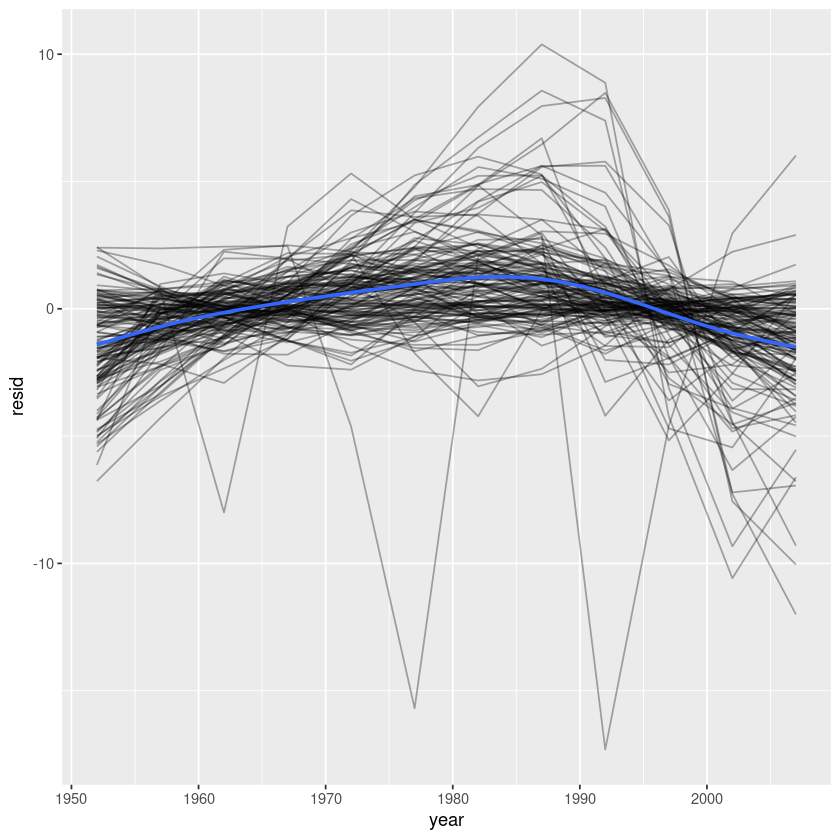

In [27]:
resids %>%
    ggplot(aes(year, resid)) +
        geom_line(aes(group = country), alpha = 1/3) +
        geom_smooth(se = FALSE)

Faceting by continent is particularly revealing:

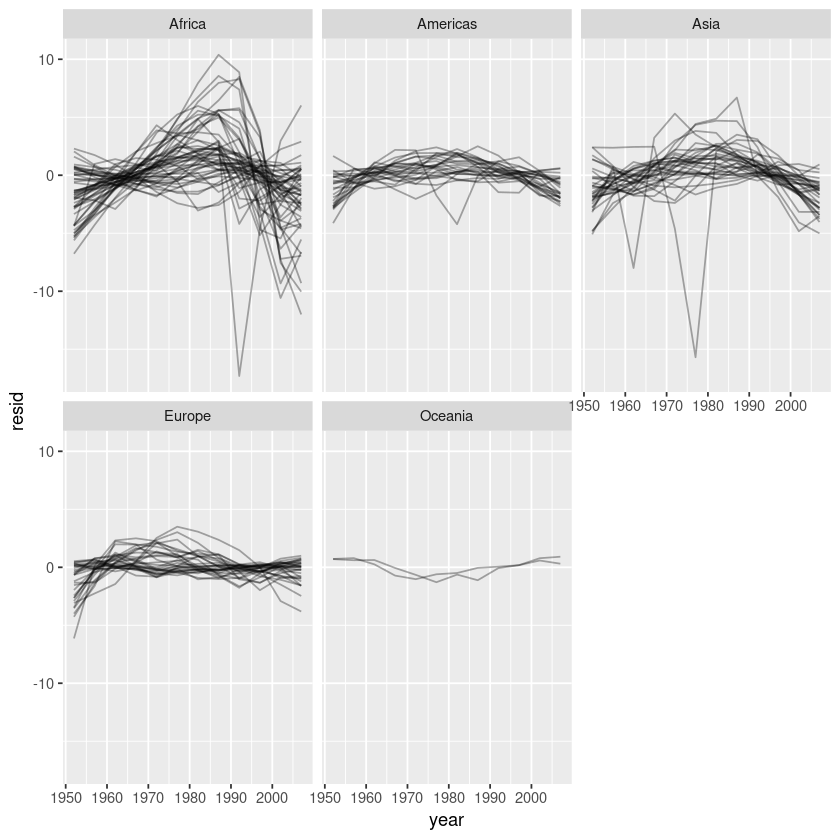

In [33]:
resids %>%
    ggplot(aes(year, resid, group = country)) +
        geom_line(alpha = 1/3) +
        facet_wrap(~continent)

It looks like we’ve missed some mild pattern. There’s also something
interesting going on in Africa: we see some very large residuals,
which suggests our model isn’t fitting so well there. We’ll explore
that more in the next section, attacking it from a slightly different
angle.

### __Model Quality__

Instead of looking at the residuals from the model, we could look at
some general measurements of model quality. You learned how to
compute some specific measures in the previous chapter. Here we’ll
show a different approach using the broom package. The broom
package provides a general set of functions to turn models into tidy
data. Here we’ll use `broom::glance()` to extract some model quality
metrics. If we apply it to a model, we get a data frame with a single
row:

In [36]:
broom::glance(nz_mod)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.9535846,0.9489431,0.8043472,205.4459,5.407324e-08,1,-13.32064,32.64128,34.096,6.469743,10,12


We can use `mutate()` and `unnest()` to create a data frame with a
row for each country:

In [37]:
by_country %>%
    mutate(glance = map(model, broom::glance)) %>%
    unnest(glance)

country,continent,data,model,resids,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<fct>,<fct>,<list>,<list>,<list>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
Afghanistan,Asia,"1.952000e+03, 1.957000e+03, 1.962000e+03, 1.967000e+03, 1.972000e+03, 1.977000e+03, 1.982000e+03, 1.987000e+03, 1.992000e+03, 1.997000e+03, 2.002000e+03, 2.007000e+03, 2.880100e+01, 3.033200e+01, 3.199700e+01, 3.402000e+01, 3.608800e+01, 3.843800e+01, 3.985400e+01, 4.082200e+01, 4.167400e+01, 4.176300e+01, 4.212900e+01, 4.382800e+01, 8.425333e+06, 9.240934e+06, 1.026708e+07, 1.153797e+07, 1.307946e+07, 1.488037e+07, 1.288182e+07, 1.386796e+07, 1.631792e+07, 2.222742e+07, 2.526840e+07, 3.188992e+07, 7.794453e+02, 8.208530e+02, 8.531007e+02, 8.361971e+02, 7.399811e+02, 7.861134e+02, 9.780114e+02, 8.523959e+02, 6.493414e+02, 6.353414e+02, 7.267341e+02, 9.745803e+02","-507.5343, 0.2753287, -1.106295, -0.9519382, -0.6635816, -0.01722494, 0.6741317, 1.647488, 1.686845, 1.278202, 0.7535583, -0.5340851, -1.544728, -1.222372, -129.8305, 16.46226, -0.3108827, 0.2892301, 0.934343, 1.861456, 1.854569, 1.399681, 0.8287943, -0.5050929, -1.56198, -1.285867, 2, 29.90729, 31.28394, 32.66058, 34.03722, 35.41387, 36.79051, 38.16716, 39.5438, 40.92044, 42.29709, 43.67373, 45.05037, 0, 1, -3.464102, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, -6857.189, 59.7913, 0.1896554, 0.1060312, 0.02240704, -0.06121716, -0.1448414, -0.2284656, -0.3120898, -0.395714, -0.4793382, -0.5629624, 1.288675, 1.27328, 1, 2, 1e-07, 2, 10, lm(formula = lifeExp ~ year, data = df), lifeExp ~ year, 28.801, 30.332, 31.997, 34.02, 36.088, 38.438, 39.854, 40.822, 41.674, 41.763, 42.129, 43.828, 1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002, 2007","1.952000e+03, 1.957000e+03, 1.962000e+03, 1.967000e+03, 1.972000e+03, 1.977000e+03, 1.982000e+03, 1.987000e+03, 1.992000e+03, 1.997000e+03, 2.002000e+03, 2.007000e+03, 2.880100e+01, 3.033200e+01, 3.199700e+01, 3.402000e+01, 3.608800e+01, 3.843800e+01, 3.985400e+01, 4.082200e+01, 4.167400e+01, 4.176300e+01, 4.212900e+01, 4.382800e+01, 8.425333e+06, 9.240934e+06, 1.026708e+07, 1.153797e+07, 1.307946e+07, 1.488037e+07, 1.288182e+07, 1.386796e+07, 1.631792e+07, 2.222742e+07, 2.526840e+07, 3.188992e+07, 7.794453e+02, 8.208530e+02, 8.531007e+02, 8.361971e+02, 7.399811e+02, 7.861134e+02, 9.780114e+02, 8.523959e+02, 6.493414e+02, 6.353414e+02, 7.267341e+02, 9.745803e+02, -1.106295e+00, -9.519382e-01, -6.635816e-01, -1.722494e-02, 6.741317e-01, 1.647488e+00, 1.686845e+00, 1.278202e+00, 7.535583e-01, -5.340851e-01, -1.544728e+00, -1.222372e+00",0.9477123,0.9424835,1.222788,181.2494,9.835213e-08,1,-18.34693,42.69387,44.14859,14.95210,10,12
Albania,Europe,"1952.000, 1957.000, 1962.000, 1967.000, 1972.000, 1977.000, 1982.000, 1987.000, 1992.000, 1997.000, 2002.000, 2007.000, 55.230, 59.280, 64.820, 66.220, 67.690, 68.930, 70.420, 72.000, 71.581, 72.950, 75.651, 76.423, 1282697.000, 1476505.000, 1728137.000, 1984060.000, 2263554.000, 2509048.000, 2780097.000, 3075321.000, 3326498.000, 3428038.000, 3508512.000, 3600523.000, 1601.056, 1942.284, 2312.889, 2760.197, 3313.422, 3533.004, 3630.881, 3738.933, 2497.438, 3193.055, 4604.212, 5937.030","-594.0725, 0.3346832, -3.999128, -1.622544, 2.24404, 1.970624, 1.767207, 1.333791, 1.150375, 1.056959, -1.035457, -1.339873, -0.312289, -1.213705, -237.0586, 20.01115, 3.248124, 2.926981, 2.675838, 2.194694, 1.963551, 1.822408, -0.3177351, -0.6698783, 0.3099785, -0.6391646, 2, 59.22913, 60.90254, 62.57596, 64.24938, 65.92279, 67.59621, 69.26962, 70.94304, 72.61646, 74.28987, 75.96329, 77.63671, 0, 1, -3.464102, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, -6857.189, 59.7913, 0.1896554, 0.1060312, 0.02240704, -0.06121716, -0.1448414, -0.2284656, -0.3120898, -0.395714, -0.4793382, -0.5629624, 1.28

This isn’t quite the output we want, because it still includes all the
list-columns. This is default behavior when `unnest()` works on
single-row data frames. To suppress these columns we use `.drop = TRUE` :

In [38]:
glance <- by_country %>%
    mutate(glance = map(model, broom::glance)) %>%
    unnest(glance, .drop = TRUE)

Warning message:
“The `.drop` argument of `unnest()` is deprecated as of tidyr 1.0.0.
All list-columns are now preserved.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [39]:
glance

country,continent,data,model,resids,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<fct>,<fct>,<list>,<list>,<list>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
Afghanistan,Asia,"1.952000e+03, 1.957000e+03, 1.962000e+03, 1.967000e+03, 1.972000e+03, 1.977000e+03, 1.982000e+03, 1.987000e+03, 1.992000e+03, 1.997000e+03, 2.002000e+03, 2.007000e+03, 2.880100e+01, 3.033200e+01, 3.199700e+01, 3.402000e+01, 3.608800e+01, 3.843800e+01, 3.985400e+01, 4.082200e+01, 4.167400e+01, 4.176300e+01, 4.212900e+01, 4.382800e+01, 8.425333e+06, 9.240934e+06, 1.026708e+07, 1.153797e+07, 1.307946e+07, 1.488037e+07, 1.288182e+07, 1.386796e+07, 1.631792e+07, 2.222742e+07, 2.526840e+07, 3.188992e+07, 7.794453e+02, 8.208530e+02, 8.531007e+02, 8.361971e+02, 7.399811e+02, 7.861134e+02, 9.780114e+02, 8.523959e+02, 6.493414e+02, 6.353414e+02, 7.267341e+02, 9.745803e+02","-507.5343, 0.2753287, -1.106295, -0.9519382, -0.6635816, -0.01722494, 0.6741317, 1.647488, 1.686845, 1.278202, 0.7535583, -0.5340851, -1.544728, -1.222372, -129.8305, 16.46226, -0.3108827, 0.2892301, 0.934343, 1.861456, 1.854569, 1.399681, 0.8287943, -0.5050929, -1.56198, -1.285867, 2, 29.90729, 31.28394, 32.66058, 34.03722, 35.41387, 36.79051, 38.16716, 39.5438, 40.92044, 42.29709, 43.67373, 45.05037, 0, 1, -3.464102, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, -6857.189, 59.7913, 0.1896554, 0.1060312, 0.02240704, -0.06121716, -0.1448414, -0.2284656, -0.3120898, -0.395714, -0.4793382, -0.5629624, 1.288675, 1.27328, 1, 2, 1e-07, 2, 10, lm(formula = lifeExp ~ year, data = df), lifeExp ~ year, 28.801, 30.332, 31.997, 34.02, 36.088, 38.438, 39.854, 40.822, 41.674, 41.763, 42.129, 43.828, 1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002, 2007","1.952000e+03, 1.957000e+03, 1.962000e+03, 1.967000e+03, 1.972000e+03, 1.977000e+03, 1.982000e+03, 1.987000e+03, 1.992000e+03, 1.997000e+03, 2.002000e+03, 2.007000e+03, 2.880100e+01, 3.033200e+01, 3.199700e+01, 3.402000e+01, 3.608800e+01, 3.843800e+01, 3.985400e+01, 4.082200e+01, 4.167400e+01, 4.176300e+01, 4.212900e+01, 4.382800e+01, 8.425333e+06, 9.240934e+06, 1.026708e+07, 1.153797e+07, 1.307946e+07, 1.488037e+07, 1.288182e+07, 1.386796e+07, 1.631792e+07, 2.222742e+07, 2.526840e+07, 3.188992e+07, 7.794453e+02, 8.208530e+02, 8.531007e+02, 8.361971e+02, 7.399811e+02, 7.861134e+02, 9.780114e+02, 8.523959e+02, 6.493414e+02, 6.353414e+02, 7.267341e+02, 9.745803e+02, -1.106295e+00, -9.519382e-01, -6.635816e-01, -1.722494e-02, 6.741317e-01, 1.647488e+00, 1.686845e+00, 1.278202e+00, 7.535583e-01, -5.340851e-01, -1.544728e+00, -1.222372e+00",0.9477123,0.9424835,1.222788,181.2494,9.835213e-08,1,-18.34693,42.69387,44.14859,14.95210,10,12
Albania,Europe,"1952.000, 1957.000, 1962.000, 1967.000, 1972.000, 1977.000, 1982.000, 1987.000, 1992.000, 1997.000, 2002.000, 2007.000, 55.230, 59.280, 64.820, 66.220, 67.690, 68.930, 70.420, 72.000, 71.581, 72.950, 75.651, 76.423, 1282697.000, 1476505.000, 1728137.000, 1984060.000, 2263554.000, 2509048.000, 2780097.000, 3075321.000, 3326498.000, 3428038.000, 3508512.000, 3600523.000, 1601.056, 1942.284, 2312.889, 2760.197, 3313.422, 3533.004, 3630.881, 3738.933, 2497.438, 3193.055, 4604.212, 5937.030","-594.0725, 0.3346832, -3.999128, -1.622544, 2.24404, 1.970624, 1.767207, 1.333791, 1.150375, 1.056959, -1.035457, -1.339873, -0.312289, -1.213705, -237.0586, 20.01115, 3.248124, 2.926981, 2.675838, 2.194694, 1.963551, 1.822408, -0.3177351, -0.6698783, 0.3099785, -0.6391646, 2, 59.22913, 60.90254, 62.57596, 64.24938, 65.92279, 67.59621, 69.26962, 70.94304, 72.61646, 74.28987, 75.96329, 77.63671, 0, 1, -3.464102, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, -6857.189, 59.7913, 0.1896554, 0.1060312, 0.02240704, -0.06121716, -0.1448414, -0.2284656, -0.3120898, -0.395714, -0.4793382, -0.5629624, 1.28

In [40]:
glance %>%
    arrange(r.squared)

country,continent,data,model,resids,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<fct>,<fct>,<list>,<list>,<list>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
Rwanda,Africa,"1952.0000, 1957.0000, 1962.0000, 1967.0000, 1972.0000, 1977.0000, 1982.0000, 1987.0000, 1992.0000, 1997.0000, 2002.0000, 2007.0000, 40.0000, 41.5000, 43.0000, 44.1000, 44.6000, 45.0000, 46.2180, 44.0200, 23.5990, 36.0870, 43.4130, 46.2420, 2534927.0000, 2822082.0000, 3051242.0000, 3451079.0000, 3992121.0000, 4657072.0000, 5507565.0000, 6349365.0000, 7290203.0000, 7212583.0000, 7852401.0000, 8860588.0000, 493.3239, 540.2894, 597.4731, 510.9637, 590.5807, 670.0806, 881.5706, 847.9912, 737.0686, 589.9445, 785.6538, 863.0885","132.205, -0.04583147, -2.741949, -1.012791, 0.716366, 2.045523, 2.774681, 3.403838, 4.850995, 2.882153, -17.30969, -4.592533, 2.962625, 6.020782, -143.6964, -2.740323, 1.389955, 2.692936, 3.395916, 3.998897, 5.419878, 3.424859, -16.79316, -4.10218, 3.426801, 6.458782, 2, 42.74195, 42.51279, 42.28363, 42.05448, 41.82532, 41.59616, 41.367, 41.13785, 40.90869, 40.67953, 40.45038, 40.22122, 0, 1, -3.464102, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, -6857.189, 59.7913, 0.1896554, 0.1060312, 0.02240704, -0.06121716, -0.1448414, -0.2284656, -0.3120898, -0.395714, -0.4793382, -0.5629624, 1.288675, 1.27328, 1, 2, 1e-07, 2, 10, lm(formula = lifeExp ~ year, data = df), lifeExp ~ year, 40, 41.5, 43, 44.1, 44.6, 45, 46.218, 44.02, 23.599, 36.087, 43.413, 46.242, 1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002, 2007","1.952000e+03, 1.957000e+03, 1.962000e+03, 1.967000e+03, 1.972000e+03, 1.977000e+03, 1.982000e+03, 1.987000e+03, 1.992000e+03, 1.997000e+03, 2.002000e+03, 2.007000e+03, 4.000000e+01, 4.150000e+01, 4.300000e+01, 4.410000e+01, 4.460000e+01, 4.500000e+01, 4.621800e+01, 4.402000e+01, 2.359900e+01, 3.608700e+01, 4.341300e+01, 4.624200e+01, 2.534927e+06, 2.822082e+06, 3.051242e+06, 3.451079e+06, 3.992121e+06, 4.657072e+06, 5.507565e+06, 6.349365e+06, 7.290203e+06, 7.212583e+06, 7.852401e+06, 8.860588e+06, 4.933239e+02, 5.402894e+02, 5.974731e+02, 5.109637e+02, 5.905807e+02, 6.700806e+02, 8.815706e+02, 8.479912e+02, 7.370686e+02, 5.899445e+02, 7.856538e+02, 8.630885e+02, -2.741949e+00, -1.012791e+00, 7.163660e-01, 2.045523e+00, 2.774681e+00, 3.403838e+00, 4.850995e+00, 2.882153e+00, -1.730969e+01, -4.592533e+00, 2.962625e+00, 6.020782e+00",0.01715964,-0.08112440,6.558269,0.1745923,0.6848927,1,-38.50205,83.00411,84.45883,430.1090,10,12
Botswana,Africa,"1952.0000, 1957.0000, 1962.0000, 1967.0000, 1972.0000, 1977.0000, 1982.0000, 1987.0000, 1992.0000, 1997.0000, 2002.0000, 2007.0000, 47.6220, 49.6180, 51.5200, 53.2980, 56.0240, 59.3190, 61.4840, 63.6220, 62.7450, 52.5560, 46.6340, 50.7280, 442308.0000, 474639.0000, 512764.0000, 553541.0000, 619351.0000, 781472.0000, 970347.0000, 1151184.0000, 1342614.0000, 1536536.0000, 1630347.0000, 1639131.0000, 851.2411, 918.2325, 983.6540, 1214.7093, 2263.6111, 3214.8578, 4551.1421, 6205.8839, 7954.1116, 8647.1423, 11003.6051, 12569.8518","-65.49586, 0.06066853, -5.307115, -3.614458, -2.015801, -0.5411434, 1.881514, 4.873171, 6.734829, 8.569486, 7.389143, -3.103199, -9.328542, -5.537885, -189.1313, 3.627451, -0.4656616, 0.8496905, 3.113043, 5.945395, 7.647747, 9.323099, 7.983451, -2.668197, -9.052845, -5.421493, 2, 52.92912, 53.23246, 53.5358, 53.83914, 54.14249, 54.44583, 54.74917, 55.05251, 55.35586, 55.6592, 55.96254, 56.26588, 0, 1, -3.464102, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, 0.2886751, -6857.189, 59.7913, 0.1896554, 0.1060312, 0.02240704, -0.06121716, -0.1448414, -0.2284656, -0.3120898, -0.395714, -0.4793382, -0.5629624, 1.288675, 1.27328, 1, 2, 1e-07, 2, 10, lm(formula = lifeExp ~ year, data = df), lifeExp ~ year, 47.622, 49.618, 51.52, 53.298, 56.024, 59.319, 61

The worst models all appear to be in Africa. Let’s double-check that
with a plot. Here we have a relatively small number of observations
and a discrete variable, so `geom_jitter()` is effective:

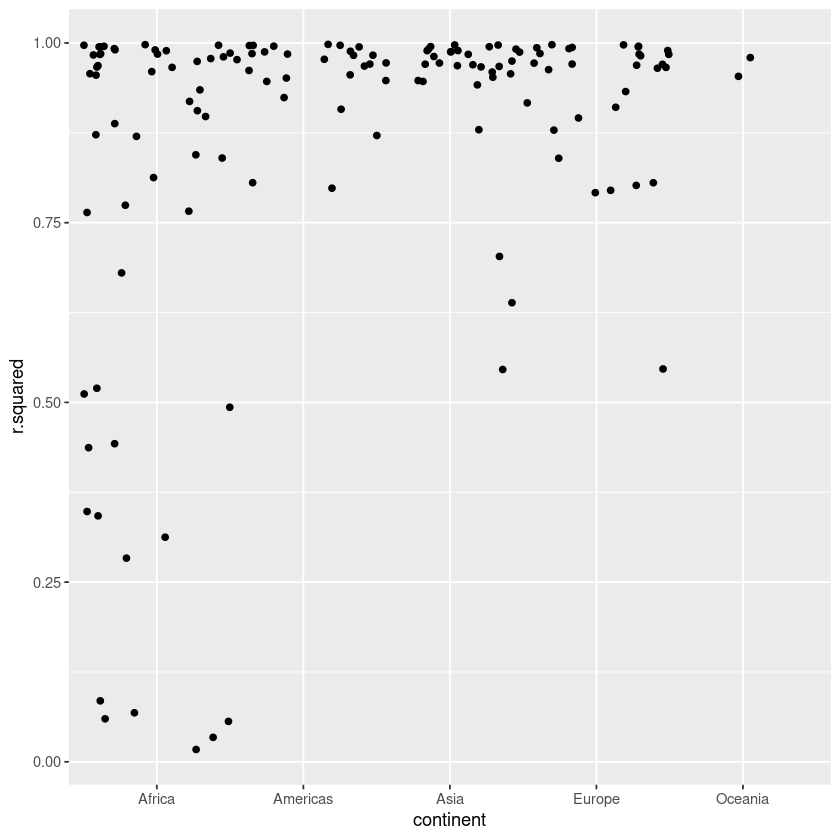

In [41]:
glance %>%
    ggplot(aes(continent, r.squared)) +
        geom_jitter(width = 0.5)

We could pull out the countries with particularly bad R 2 and plot the
data:

In [42]:
bad_fit <- filter(glance, r.squared < 0.25)

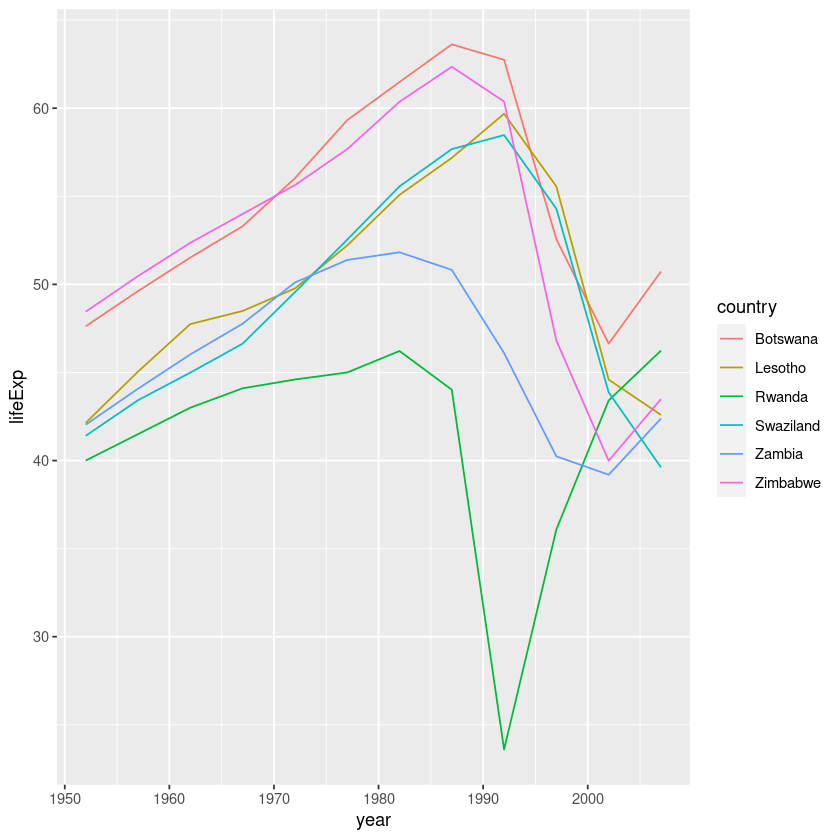

In [43]:
gapminder %>%
    semi_join(bad_fit, by = 'country') %>%
    ggplot(aes(year, lifeExp, color = country)) +
        geom_line()

We see two main effects here: the tragedies of the HIV/AIDS epidemic and the Rwandan genocide.